We now try to implement a simple Extreme Gradient Boosting algorithm from scratch. Our version isn't as robust as the library `xgboost`, but it retains the basic features. Our implementation is heavily inspired by the method taught by Andrew Ng in his coursera course.

In [1]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class Node:
    def __init__(self, feature_to_split=None, threshold=None, left=None, right=None, data=None):
        self.feature_to_split = feature_to_split
        self.threshold = threshold
        self.left = left
        self.right = right
        self.data = data

In [3]:
class Custom_xgb:
    def __init__(self, n_estimators=5, learning_rate=0.1, max_depth=3, min_n_samples=2, lambda_reg=1):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_n_samples = min_n_samples
        self.lambda_reg = lambda_reg
        self.trees = []
        self.base_pred = None


    def similarity(self, gradients, hessians):
        sum_grads = np.sum(gradients)
        sum_hess = np.sum(hessians)
        return (sum_grads**2)/(sum_hess + self.lambda_reg)
    

    def xgb_gain(self, g, h, g_left, h_left, g_right, h_right):
        score_root = self.similarity(g, h)
        score_left = self.similarity(g_left, h_left)
        score_right = self.similarity(g_right, h_right)
        return  0.5 * (score_left + score_right - score_root)
    

    def leaf_weight(self, gradients, hessians):
        sum_grads = np.sum(gradients)
        sum_hess = np.sum(hessians)
        return -sum_grads/(sum_hess + self.lambda_reg)
    

    def find_best_split(self, X: pd.DataFrame, gradients, hessians):        

        # store and update the bests when a better gain is found
        best_feature = None
        best_gain = -1000
        best_threshold = None
        best_mask = None

        # take a feature, then go through all values of that feature, taking them as the new threshold to check gain
        for feature in X.columns: 
            thresholds = X[feature].unique()
            for threshold in thresholds:
                # divide into y_left and y_right
                mask = (X[feature] <= threshold).values

                if sum(mask)==0 or sum(~mask)==0:
                    continue

                g_left, g_right = gradients[mask], gradients[~mask]
                h_left, h_right = hessians[mask], hessians[~mask]


                # check gain for the current threshold and feature, and update if a better gain is found
                current_gain = self.xgb_gain(gradients, hessians, g_left, h_left, g_right, h_right)

                if current_gain > best_gain:
                    best_gain = current_gain
                    best_feature = feature
                    best_threshold = threshold
                    best_mask = mask
            

        if best_feature is None:
            return None, None, None, None, None, None, None, None


        return (best_feature, best_threshold, 
                X[best_mask], gradients[best_mask], hessians[best_mask],
                X[~best_mask], gradients[~best_mask], hessians[~best_mask])
    

    def build_tree(self, X: pd.DataFrame, gradients, hessians, depth=0):
        n_samples, _ = X.shape

        # if we satisfy the conditions, we return a leaf node
        if depth >= self.max_depth or n_samples < self.min_n_samples:
            leaf_value = self.leaf_weight(gradients, hessians)
            return Node(data=leaf_value)
        
        
        
        best_feature, best_threshold, X_left, g_left, h_left, X_right, g_right, h_right = self.find_best_split(X, gradients, hessians) 

        # return a leaf node if no gain was found
        if best_feature is None:
            leaf_value = self.leaf_weight(gradients, hessians)
            return Node(data=leaf_value)


        left_child = self.build_tree(X_left, g_left, h_left, depth+1)
        right_child = self.build_tree(X_right, g_right, h_right, depth+1)

        return Node(feature_to_split=best_feature, threshold=best_threshold, left=left_child, right=right_child)


    def predict_tree(self, node, X):
        predictions = []
        for i in range(len(X)):
            row = X.iloc[i]
            current = node

            while current.data is None:
                if row[current.feature_to_split] <= current.threshold:
                    current = current.left
                else:
                    current = current.right
            predictions.append(current.data)

        return np.array(predictions)
        


    def fit(self, X, y):
        self.base_pred = np.mean(y)
        y_pred = np.full(len(y), self.base_pred)

        for _ in range(self.n_estimators):
            gradients = y_pred - y
            hessians = np.ones(len(y))

            tree = self.build_tree(X, gradients, hessians, depth=0)
            self.trees.append(tree)

            update_values = self.predict_tree(tree, X)
            y_pred += self.learning_rate*update_values




    def predict(self, X):
        final_predictions = np.full(len(X), self.base_pred)


        for tree in self.trees:
            final_predictions += self.learning_rate*self.predict_tree(tree, X)

        return final_predictions


We now use the preprocessing steps from the pearson coefficient notebook. Additionally, there are some missing values in the `MC` column. As our implementation cannot safely handle missing values, and we could not think about any suitable ways to impute the missing values, we are dropping the datapoints with missing values.

In [4]:
# preprocessing steps from previous notebook
df = pd.read_excel("./Curated_data_1234_datapoints.xlsx")

df.columns = df.columns.str.strip()
df = df.drop(columns=["Reference DOI", "Unnamed: 23"], axis=1)

df.dropna(inplace=True)
df['Support Loading [wt.%]'] = 100 - df['Metal Loading [wt.%]'] - df['Promoter 1 loading [wt.%]'] - df['Promoter 2 loading [wt.%]']

y = df.iloc[:, 0]
y = y/1000  #units aren't consistent

X = (df[["Metal Loading [wt.%]", "Support Loading [wt.%]", "Promoter 1 loading [wt.%]", "Promoter 2 loading [wt.%]", "SBET [m2 g-1]", "H2/CO2 [-]", "GHSV [cm3 h-1 gcat-1]", "Catalyst amount [g]", "Pressure [Mpa]", "Temperature [K]", "Calcination Temperature [K]", "Calcination duration [h]"]]).copy()

# rename the columns
column_names = ["M", "S", "PR1", "PR2", "S$_{BET}$", "H$_2$/CO$_2$", "GHSV", "MC", "P", "T", "CT", "CD"]
X.columns = column_names

display(X)

,M,S,PR1,PR2,S$_{BET}$,H$_2$/CO$_2$,GHSV,MC,P,T,CT,CD
0,4.4,88.6,6.8,0.2,9.0,10.0,115500.0,0.50,6.0,598.0,623,2.0
1,4.4,88.6,6.8,0.2,9.0,8.0,94500.0,0.50,6.0,598.0,623,2.0
2,36.5,60.8,2.7,0.0,218.0,3.0,120000.0,0.02,4.0,453.0,573,4.0
3,4.4,88.6,6.8,0.2,9.0,10.0,115500.0,0.50,4.0,598.0,623,2.0
4,36.5,60.8,2.7,0.0,218.0,3.0,60000.0,0.04,4.0,453.0,773,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1228,67.0,33.0,0.0,0.0,96.0,4.0,48000.0,0.10,5.0,513.0,623,3.0
1229,67.0,33.0,0.0,0.0,96.0,4.0,24000.0,0.10,4.0,473.0,623,3.0
1230,67.0,33.0,0.0,0.0,96.0,4.0,42000.0,0.10,4.0,493.0,623,3.0
1231,67.0,33.0,0.0,0.0,96.0,4.0,42000.0,0.10,4.0,513.0,623,3.0


Just like before, we now split the data into 85:15 train:test, and do the traininig and prediction. We use a smaller number of estimators as this version runs slower than the standard xgboost.

In [5]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.15, random_state=10)


model = Custom_xgb(n_estimators=30, max_depth=8, learning_rate=0.2, lambda_reg=1)


model.fit(X_train, y_train)

y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)


#calculate metrics to plot
rmse = sklearn.metrics.root_mean_squared_error(y_test, y_pred_test)
r_squared_test = sklearn.metrics.r2_score(y_test, y_pred_test)
r_squared_train = sklearn.metrics.r2_score(y_train, y_pred_train)

print(f"RMSE Score: {rmse:.2f}\n"
      f"R squared on test data: {r_squared_test:.2f}\n"
      f"R squared on training data: {r_squared_train:.2f}")
    

RMSE Score: 0.12
R squared on test data: 0.80
R squared on training data: 0.98


In [6]:
# combine test and train predictions to use sns hue

plot_df_test = pd.DataFrame()
plot_df_test["Actual STY"] = y_test
plot_df_test["Predicted STY"] = y_pred_test
plot_df_test["type"] = "Test data"


plot_df_train = pd.DataFrame()
plot_df_train["Actual STY"] = y_train
plot_df_train["Predicted STY"] = y_pred_train
plot_df_train["type"] = "Training data"


plot_df = pd.concat([plot_df_test, plot_df_train])


display(plot_df)

,Actual STY,Predicted STY,type
429,0.134368,0.103050,Test data
1122,0.001734,0.053444,Test data
1201,0.412400,0.277252,Test data
1103,0.002841,0.002423,Test data
669,0.065319,0.052920,Test data
...,...,...,...
1032,0.009191,0.008548,Training data
733,0.054771,0.039256,Training data
1207,0.932800,0.952303,Training data
527,0.100335,0.156366,Training data


Text(0.5, 1.015, 'Model Prediction by Extreme Gradient Boost (XGB)')

<Figure size 640x480 with 0 Axes>

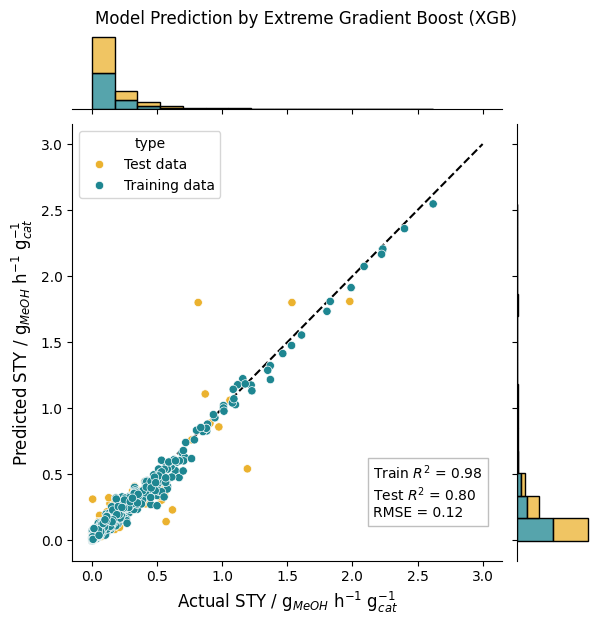

In [7]:
plt.figure()

cpalette = {"Training data": '#1e8691', "Test data":"#ebb22f"}

# using a JointGrid. jointplot forces a KDE with scatter, or heatmap with hist
ax = sns.JointGrid(plot_df, 
                   x="Actual STY", 
                   y="Predicted STY", 
                   hue="type",
                   palette=cpalette
                   )


ax.plot_marginals(sns.histplot,
                  stat='density',
                  common_norm=False,
                  multiple="stack",
                  bins=15
                  )


ax.plot_joint(sns.scatterplot)


# the diagonal
ax.ax_joint.plot([0, 3], [0, 3], 'k--', zorder=0)



stats_text = (f"Train $R^2$ = {r_squared_train:.2f}\n"
              f"Test $R^2$ = {r_squared_test:.2f}\n"
              f"RMSE = {rmse:.2f}")


ax.ax_joint.text(0.7, 0.1, stats_text, transform=ax.ax_joint.transAxes, 
                 fontsize=10, bbox=dict(facecolor='white', alpha=0.5, edgecolor='gray'))


ax.set_axis_labels('Actual STY / g$_{MeOH}$ h$^{-1}$ g$_{cat}^{-1}$', 
                  'Predicted STY / g$_{MeOH}$ h$^{-1}$ g$_{cat}^{-1}$', fontsize=12)


ax.figure.suptitle("Model Prediction by Extreme Gradient Boost (XGB)", y = 1.015)